In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from datetime import datetime

import re

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chenmo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [45]:
df = pd.read_csv('../../listings.csv')
df_ori = df
df.columns.tolist()

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'source',
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated',
 'has_availability',
 'availability_30

In [46]:
df.shape

(7566, 75)

## Drop all descriptions and useless columns.

Among all the features, you will find that the values ​​of some features have no practical meaning (such as id, scrape_id, host_id), and some features are descriptive information, which is not helpful for model analysis (such as listing_url, description, picture_url, etc., In addition, some data describe the future information, which is not very helpful to the data that needs to be analyzed (such as has_availability, availability_30, etc.). After comparing and analyzing one by one, the following characteristics are determined, and the reasons are as follows:

- Moot information：id，scrape_id，host_id
- Descriptive information：listing_url，source，name，description，neighborhood_overview，picture_url，host_url，host_name，host_about，host_thumbnail_url，host_picture_url， license
- Data that is not helpful for data analysis：last_scraped， host_location， calendar_last_scraped， calendar_updated， last_review
- Describe future data：has_availability，availability_30，availability_60，availability_90，availability_365

- listing_url
- scrape_id
- last_scraped
- source
- name
- description
- neighborhood_overview
- host_location
- picture_url
- host_id
- host_url
- host_name
- host_about
- host_thumbnail_url
- host_picture_url
- calendar_last_scraped
- license
- calendar_updated
- last_review
- has_availability
- availability_30
- availability_60
- availability_90
- availability_365

In [48]:
desc_list = ['listing_url','scrape_id','last_scraped','source','name','description','neighborhood_overview', 'host_location',
        'picture_url','host_id','host_url','host_name','host_about','host_thumbnail_url','host_picture_url',
        'calendar_last_scraped','license', 'calendar_updated', 'last_review', 'has_availability', 'availability_30', 'availability_60',
        'availability_90', 'availability_365']

df.drop(desc_list, axis=1, inplace=True)

### Drop missing data¶

For the features that are all empty in the data, they need to be deleted. For the features of missing part of the data, it can be replaced by using **mean** or **median** according to the attributes of the data.

In [4]:
def missing_data(df):
    total = df.isnull().sum()
    percent = (df.isnull().sum()/df.isnull().count()*100)
    missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

    types = []
    for col in df.columns:
        dtype = str(df[col].dtype)
        types.append(dtype)

    missing_values['Types'] = types
    missing_values.sort_values('Total', ascending=False, inplace=True)

    return np.transpose(missing_values)

def print_nan(df_col):
    print("Null values:", df_col.isna().sum())
    print(f"Proportion: {round((df_col.isna().sum()/len(df))*100, 1)}%")
    
    if type(df_col[0]) == 'int':
        print("Mean:", round(df_col.mean(),0))
        print("Median:", df_col.median())

def get_empty_df(df_, list_):
    return df_[df_.loc[ :, list_].isnull().sum(axis=1) == len(list_)]


pd.set_option('display.max_rows', None)  # Set the maximum number of lines to display

bathrooms                       100.000000
neighbourhood_group_cleansed    100.000000
host_response_time               48.030663
host_response_rate               48.030663
host_acceptance_rate             44.607454
neighbourhood                    44.567803
host_neighbourhood               30.822099
review_scores_value              19.653714
review_scores_checkin            19.627280
review_scores_location           19.627280
dtype: float64


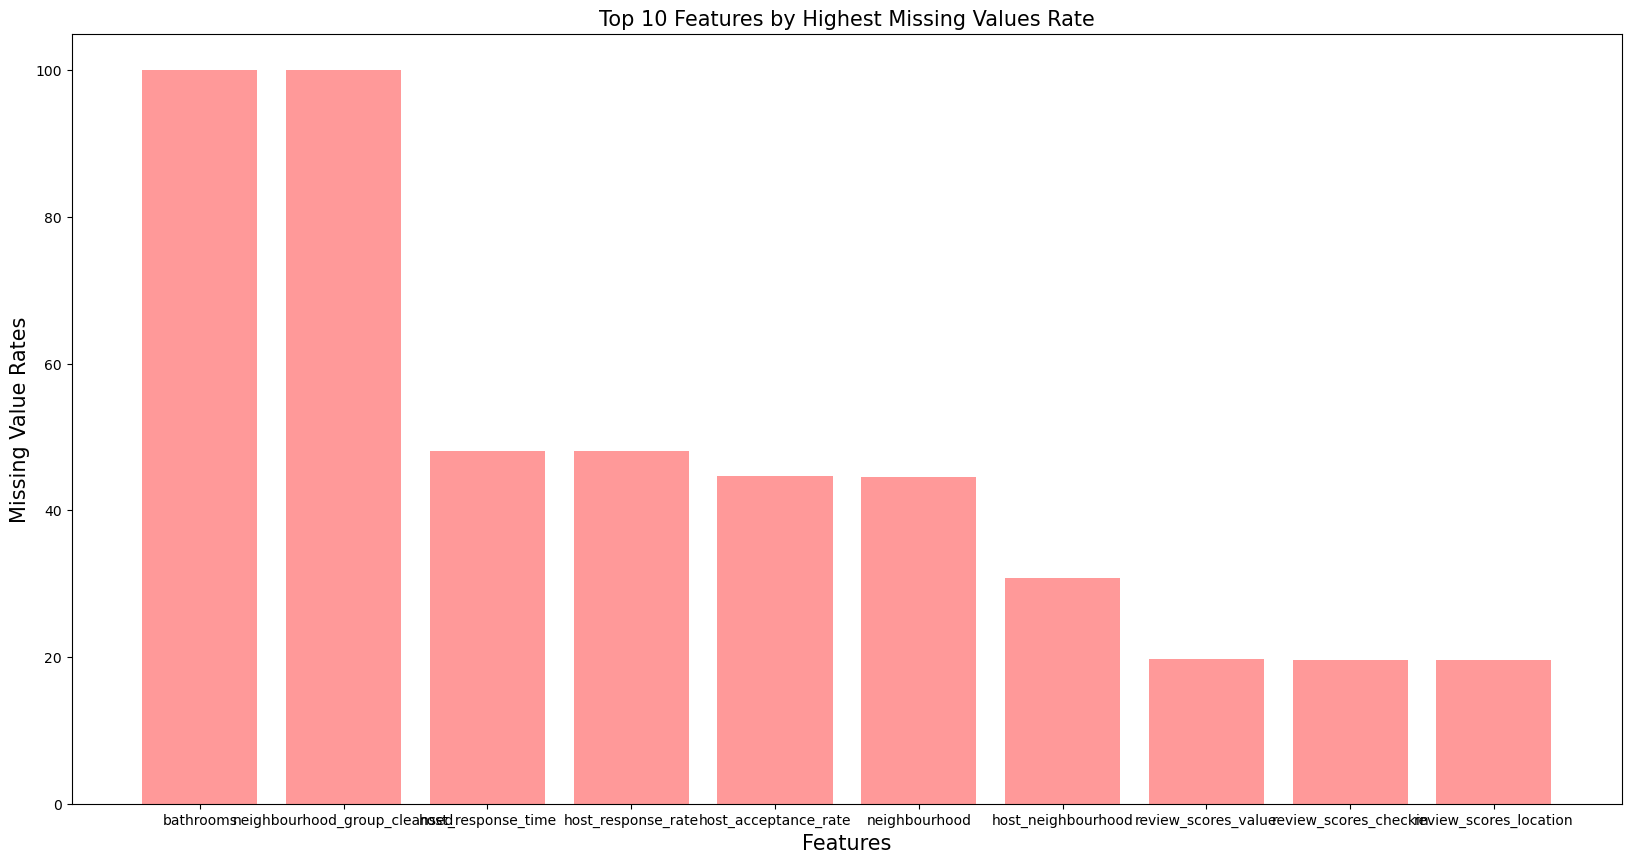

In [49]:
missing_values_count = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)

print(missing_values_count[:10])

plt.figure(figsize=(20,10))
base_color = sns.color_palette()[0]
plt.xlabel('Features', fontsize=15)
plt.ylabel('Missing Value Rates', fontsize=15)
plt.title('Top 10 Features by Highest Missing Values Rate', fontsize=15)
plt.bar(missing_values_count[:10].index.values, missing_values_count[:10], color='#ff9999')
plt.show()

In [6]:
empty_list = ['bathrooms', 'neighbourhood_group_cleansed']

df.drop(empty_list, axis=1, inplace=True)

### Drop duplicate columns

#### neighbourhood

Since the data selected this time are all from Dublin city, there is little difference between `neighbourhood`, `host_neighborhood`, `neighborhood_group_cleansed` and `neighborhood_cleansed`. Since the values ​​of `neighborhood_group_cleansed` and `neighborhood_cleansed` are all empty, and 8% of `odhood` null, and `neighborhood_group_cleansed` all have values, so delete `neighborhood` and `neighborhood`, leaving `neighborhood_cleansed`.

In [7]:
print_nan(df['neighbourhood_cleansed'])

Null values: 0
Proportion: 0.0%


In [8]:
print_nan(df['neighbourhood'])

Null values: 3372
Proportion: 44.6%


In [9]:
print_nan(df['host_neighbourhood'])

Null values: 2332
Proportion: 30.8%


In [10]:
neighbourhood_list = ['neighbourhood', 'host_neighbourhood']

df.drop(neighbourhood_list, axis=1, inplace=True)

#### Drop host_listing variables

- calculated_host_listings_count：The calculated total number of host listings.
- host_total_listings_count：The total number of all listings the host has on Airbnb.
- host_listings_count：The number of active listings the host has on Airbnb.

As can be seen, `calculated_host_listings_count` is more accurate than `host_listings_count` and `host_total_listings_count`.

In [11]:
host_count_list = ['host_listings_count','host_total_listings_count']

df.drop(host_count_list, axis=1, inplace=True)

There are multiple columns for minimum and maximum night stays, but the two main ones will be used as there are few differences between e.g. minimum_nights and minimum_minimum_nights. The latter presumably refers to the fact that min/max night stays can vary over the year. The default (i.e. most frequently applied) min/max night stay values will be used instead.

In [12]:
night_list = ['minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights',
              'maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm']

df.drop(night_list, axis=1, inplace=True)

In [13]:
df.columns.tolist()

['id',
 'host_since',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'first_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'reviews_per_month']

## Numeric data

In [14]:
# Numeric columns
numeric_columns = [
 'latitude',
 'longitude',

 'host_since',  # host_days_active
 'host_days_active',

 'accommodates',
 'bedrooms',
 'beds',
 'price',
 'minimum_nights',
 'maximum_nights',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'reviews_per_month']

### host_since
This is a datetime column, and will be converted into a measure of the number of days that a host has been on the platform, measured from the date that the data was scraped (11 September, 2022). 

In [15]:
# Converting to datetime
df['host_since'] = pd.to_datetime(df['host_since']) 

# Calculating the number of days
df['host_days_active'] = (datetime(2022, 9, 11) - df['host_since']).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df['host_days_active'].fillna(df['host_days_active'].mean(), inplace=True)

df['host_days_active'].value_counts(normalize=True)

Mean days as host: 2235.0
Median days as host: 2335.0


1953.0    0.009252
2706.0    0.007930
1989.0    0.006609
2325.0    0.006080
1734.0    0.005022
25.0      0.004494
4380.0    0.004097
145.0     0.003569
1962.0    0.003172
3138.0    0.002908
1819.0    0.002643
1645.0    0.002643
2279.0    0.002643
2322.0    0.002511
3333.0    0.002511
2324.0    0.002379
2343.0    0.002379
1397.0    0.002379
2157.0    0.002379
2600.0    0.002379
1285.0    0.002115
2733.0    0.002115
2062.0    0.002115
2882.0    0.001983
3367.0    0.001850
2135.0    0.001850
2624.0    0.001850
2327.0    0.001850
2580.0    0.001850
2771.0    0.001850
2875.0    0.001850
1609.0    0.001850
2265.0    0.001850
87.0      0.001718
2277.0    0.001718
2303.0    0.001718
2523.0    0.001718
2294.0    0.001718
2533.0    0.001586
2566.0    0.001586
2428.0    0.001586
1517.0    0.001586
2967.0    0.001586
2057.0    0.001586
2628.0    0.001454
2407.0    0.001454
2307.0    0.001454
2751.0    0.001454
2661.0    0.001454
4412.0    0.001454
1632.0    0.001454
2128.0    0.001454
2520.0    0.

### price

In [16]:
print_nan(df['price'])

df['price'] = df['price'].replace('[\$,]', '', regex=True).astype('float64')

Null values: 0
Proportion: 0.0%


**Outlier detection**

Outlier detection is judged based on the principle of three times the standard deviation, that is, if the dispersion of a value exceeds three times the standard deviation of the average value of the data, the value is considered an outlier.

In [17]:
# Outlier detection
# Outlier detection is judged based on the principle of three times the standard deviation, 
# that is, if the dispersion of a value exceeds three times the standard deviation of the average value of the data, 
# the value is considered an outlier.
for col in numeric_columns:
    mean = df[col].mean()
    std = df[col].std()
    
    # Replacing null values with the mean
    df[col].fillna(mean, inplace=True)
    
    # Outlier detection
    upper_bound = mean + 3*std
    lower_bound = mean - 3*std
    df.loc[df[col] > upper_bound, col] = upper_bound
    df.loc[df[col] < lower_bound, col] = lower_bound

# # feature normalization
# for col in numeric_columns:
#     min_val = df[col].min()
#     max_val = df[col].max()
#     df[col] = (df[col] - min_val) / (max_val - min_val)

### accommodates

Indicates how many adults a listing can accommodate.

In [18]:
df['accommodates'].value_counts()

2.000000    3579
4.000000    1354
1.000000     979
6.000000     517
3.000000     417
5.000000     359
7.000000     134
8.000000     132
8.671544      95
Name: accommodates, dtype: int64

In [19]:
df['price'].value_counts()

100.000000     235
50.000000      234
150.000000     205
120.000000     187
200.000000     184
70.000000      181
60.000000      180
80.000000      174
90.000000      153
55.000000      146
40.000000      132
45.000000      131
65.000000      131
75.000000      125
250.000000     110
35.000000      102
85.000000      100
300.000000      87
140.000000      84
130.000000      80
95.000000       76
180.000000      73
110.000000      73
30.000000       68
1570.000000     66
99.000000       65
500.000000      60
160.000000      56
125.000000      53
79.000000       52
170.000000      47
400.000000      47
25.000000       47
59.000000       46
350.000000      45
69.000000       41
105.000000      40
49.000000       37
89.000000       36
39.000000       35
175.000000      35
190.000000      34
48.000000       34
36.000000       34
220.000000      33
38.000000       31
129.000000      31
115.000000      31
62.000000       30
165.000000      30
109.000000      29
71.000000       28
450.000000  

## Categorical data

In [21]:
categorical_columns = ['host_response_time', 
                       'host_response_rate', 
                       'host_acceptance_rate', 
                       'host_is_superhost',
                
                       'host_verifications',  # verification_count
                       'verification_count',
                
                       'host_has_profile_pic', 
                       'host_identity_verified', 
                       'neighbourhood_cleansed', 
                       
                       'property_type',  # property_type_category
                       'property_type_category',
                       
                       'room_type', 
                       
                       'bathrooms_text', # bathrooms_type
                       'bathrooms_type',
                       
                       'amenities',  # amenities_count
                       'amenities_count',
                       
                       'instant_bookable']

### host_response_time
host_response_time refers to the time it takes for the host to respond to guest inquiries.

In [22]:
print_nan(df['host_response_time'])

# Number of rows without a value for host_response_time which have also not yet had a review
print(len(df[df.loc[ :,['host_response_time', 'first_review'] ].isnull().sum(axis=1) == 2]))

df['host_response_time'].fillna("unknown", inplace=True)

df['host_response_time'].value_counts()

Null values: 3634
Proportion: 48.0%
789


unknown               3634
within an hour        2628
within a few hours     748
within a day           465
a few days or more      91
Name: host_response_time, dtype: int64

### host_response_rate

In [23]:
print_nan(df['host_response_rate'])

# Removing the % sign from the host_response_rate string and converting to an integer
df['host_response_rate'] = df['host_response_rate'].str[:-1].astype('float64')

print(f"Proportion of 100% host response rates: {round(((df['host_response_rate'] == 100.0).sum()/df['host_response_rate'].count())*100,1)}%")

Null values: 3634
Proportion: 48.0%
Proportion of 100% host response rates: 70.4%


In [24]:
# Bin into four categories
df['host_response_rate'] = pd.cut(df['host_response_rate'], bins=[0, 50, 90, 99, 100], 
                                  labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df['host_response_rate'] = df['host_response_rate'].astype('str')

# Replace nulls with 'unknown'
df['host_response_rate'].replace('nan', 'unknown', inplace=True)

# Category counts
df['host_response_rate'].value_counts()

unknown    3634
100%       2769
50-89%      592
90-99%      442
0-49%       129
Name: host_response_rate, dtype: int64

### host_acceptance_rate

In [25]:
print_nan(df['host_acceptance_rate'])

df['host_acceptance_rate'] = df['host_acceptance_rate'].str[:-1].astype('float64')

# # Replacing null values with the median
df['host_acceptance_rate'].fillna(df['host_acceptance_rate'].median(), inplace=True)

Null values: 3375
Proportion: 44.6%


In [26]:
# Bin into four categories
df['host_acceptance_rate'] = pd.cut(df['host_acceptance_rate'], bins=[0, 50, 90, 99, 100], 
                                    labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df['host_acceptance_rate'] = df['host_acceptance_rate'].astype('str')

# Category counts
df['host_acceptance_rate'].value_counts()

90-99%    4578
50-89%    1291
100%      1282
0-49%      415
Name: host_acceptance_rate, dtype: int64

### host_is_superhost

In [27]:
print_nan(df['host_is_superhost'])

df['host_is_superhost'].replace({'f': 0, 't': 1}, inplace=True)

df['host_is_superhost'].value_counts()

Null values: 0
Proportion: 0.0%


0    6589
1     977
Name: host_is_superhost, dtype: int64

### host_verifications

`host_verifications` can be preprocessed by counting encoding, that is, counting the number of verification methods for each customer, and then processing these numbers as features. For example, if a customer has 5 verification methods, you can set the number of verification methods of the customer to 5 and put it into the model as a feature.

In [28]:
df['verification_count'] = df['host_verifications'].apply(lambda x: len(eval(x)))
df['verification_count'].value_counts()

2    5934
3     930
1     696
0       6
Name: verification_count, dtype: int64

### host_has_profile_pic

In [29]:
df['host_has_profile_pic'].replace({'f': 0, 't': 1}, inplace=True)
df['host_has_profile_pic'].value_counts()

1    7445
0     121
Name: host_has_profile_pic, dtype: int64

### host_identity_verified

In [30]:
df['host_identity_verified'].replace({'f': 0, 't': 1}, inplace=True)
df['host_identity_verified'].value_counts()

1    5629
0    1937
Name: host_identity_verified, dtype: int64

### neighbourhood_cleansed

In [31]:
df['neighbourhood_cleansed'].value_counts()

Dublin City              5566
Dn Laoghaire-Rathdown     905
Fingal                    757
South Dublin              338
Name: neighbourhood_cleansed, dtype: int64

### property_type

`Property type` refers to the type of listing, which may be apartments, villas, houses, etc. In order to reduce the workload of analysis, some data are merged into the main types, and the types are mainly divided into four categories: Entire House, Private Room, Hotel/Motel, Others.

In [32]:
print_nan(df['property_type'])

print(df['property_type'].value_counts())

Null values: 0
Proportion: 0.0%
Entire rental unit                    1518
Private room in home                  1457
Private room in rental unit           1161
Entire home                           1080
Entire condo                           551
Private room in condo                  341
Private room in townhouse              256
Entire townhouse                       248
Private room in bed and breakfast      106
Entire serviced apartment               91
Shared room in rental unit              86
Entire cottage                          57
Shared room in home                     55
Entire guest suite                      54
Entire guesthouse                       47
Room in hotel                           39
Private room in bungalow                38
Entire loft                             34
Room in boutique hotel                  33
Entire bungalow                         32
Shared room in condo                    27
Private room in guesthouse              23
Private room in guest 

In [33]:
def classify_property_type(property_type):
    # Entire rental house
    if property_type in ("Entire rental unit", "Entire home", "Entire condo", "Entire townhouse", 
                         "Entire serviced apartment", "Entire cottage", "Entire guest suite", "Entire guesthouse", 
                         "Entire loft", "Entire bungalow", "Entire cabin", "Entire place", "Entire vacation home", 
                         "Entire villa", "Entire chalet", "Houseboat", "Castle"):
        return "Entire House"
    # private room
    elif property_type in ("Private room in home", "Private room in rental unit", "Private room in condo", 
                           "Private room in townhouse", "Private room in bed and breakfast", "Shared room in rental unit", 
                           "Shared room in home", "Private room", "Private room in guesthouse", "Private room in guest suite", 
                           "Private room in casa particular", "Private room in cottage", "Private room in serviced apartment", 
                           "Private room in cabin", "Private room in loft", "Private room in hostel", "Private room in vacation home",
                           "Private room in villa", "Private room in chalet", "Private room in tiny home", "Private room in tent", 
                           "Private room in farm stay", "Private room in floor"):
        return "Private Room"
    # Hotels and Inns
    elif property_type in ("Room in hotel", "Room in boutique hotel", "Room in hostel", "Room in aparthotel", 
                           "Room in bed and breakfast", "Room in serviced apartment"):
        return "Hotel/Motel"
    # other
    else:
        return "Others"

In [34]:
df['property_type_category'] = df['property_type'].apply(classify_property_type)
df['property_type_category'].value_counts()

Entire House    3754
Private Room    3595
Hotel/Motel      116
Others           101
Name: property_type_category, dtype: int64

### room_type

In [35]:
df['room_type'].value_counts()

Entire home/apt    3786
Private room       3563
Shared room         175
Hotel room           42
Name: room_type, dtype: int64

### bathrooms_text

In [36]:
print_nan(df['bathrooms_text'])

# Replacing null values with the median
df['bathrooms_text'].fillna('0 baths', inplace=True)

df['bathrooms_text'].value_counts()

Null values: 4
Proportion: 0.1%


1 bath               2581
1 shared bath        1495
1 private bath        978
2 baths               851
1.5 baths             569
1.5 shared baths      307
2.5 baths             275
3 baths               145
2 shared baths        121
3.5 baths              58
4 baths                37
2.5 shared baths       31
0 baths                22
0 shared baths         19
3 shared baths         16
4.5 baths              14
Shared half-bath       10
Half-bath               8
5 baths                 7
Private half-bath       4
3.5 shared baths        4
5.5 baths               3
4 shared baths          2
6 baths                 2
9.5 baths               1
7.5 baths               1
8.5 baths               1
6 shared baths          1
8 baths                 1
7 baths                 1
6.5 baths               1
Name: bathrooms_text, dtype: int64

In [37]:
def bathroom_classifier(string):
    if any(char.isdigit() for char in string):
        if 'private' not in string and 'shared' not in string:
            return string.replace('bath', 'private bath')
        return string
    else:
        if 'shared' in string:
             return '0.5 shared baths'
        else:
             return '0.5 private baths'

df['bathrooms_type'] = df['bathrooms_text'].apply(bathroom_classifier)
df['bathrooms_type'].value_counts()

1 private bath       3559
1 shared bath        1495
2 private baths       851
1.5 private baths     569
1.5 shared baths      307
2.5 private baths     275
3 private baths       145
2 shared baths        121
3.5 private baths      58
4 private baths        37
2.5 shared baths       31
0 private baths        22
0.5 private baths      22
0 shared baths         19
3 shared baths         16
4.5 private baths      14
5 private baths         7
3.5 shared baths        4
5.5 private baths       3
4 shared baths          2
6 private baths         2
7.5 private baths       1
9.5 private baths       1
8.5 private baths       1
6 shared baths          1
8 private baths         1
7 private baths         1
6.5 private baths       1
Name: bathrooms_type, dtype: int64

### amenities

In [38]:
df['amenities_count'] = df['amenities'].map(len)

### instant_bookable

In [39]:
df['instant_bookable'].replace({'f': 0, 't': 1}, inplace=True)
df['instant_bookable'].value_counts()

0    4778
1    2788
Name: instant_bookable, dtype: int64

In [40]:
# Handling Categorical Features:

from sklearn.preprocessing import LabelEncoder

# Instantiate a LabelEncoder
le = LabelEncoder()

# Encode categorical data features

for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))

# # feature normalization
# for col in categorical_columns:
#     min_val = df[col].min()
#     max_val = df[col].max()
#     df[col] = (df[col] - min_val) / (max_val - min_val)

In [41]:
df.shape

(7566, 44)

In [42]:
df.to_csv("cleaned_data.csv")

In [43]:
df.head()

,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,...,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_days_active,verification_count,property_type_category,bathrooms_type,amenities_count
0,44077,2010-08-06,4,1,3,1,1,1,1,0,...,2.0,0.0,2.0,0.0,1.85,4419.0,2,2,6,994
1,85156,2010-08-06,4,1,3,1,1,1,1,0,...,2.0,0.0,2.0,0.0,1.53,4419.0,2,2,6,657
2,159889,2011-07-01,4,1,3,0,1,1,1,1,...,3.0,0.0,3.0,0.0,2.78,4090.0,2,3,8,491
3,162809,2011-07-04,4,3,2,1,1,1,1,0,...,2.0,0.0,2.0,0.0,3.68,4087.0,2,3,6,892
4,165828,2011-07-07,4,1,3,0,1,1,1,1,...,5.0,5.0,0.0,0.0,0.48,4084.0,2,0,3,482


In [44]:
df.shape[0]

7566

### Accuracy

#### Features:

- neighbourhood_cleansed
- property_type
- room_type
- accommodates
- bedrooms
- beds
- amenities
- price
- minimum_nights
- instant_bookable
- number_of_reviews
- calculated_host_listings_count
- calculated_host_listings_count_entire_homes
- calculated_host_listings_count_private_rooms
- calculated_host_listings_count_shared_rooms
- reviews_per_month
- review_scores_value
- host_response_time
- host_response_rate
- host_acceptance_rate
- host_is_superhost
- host_verifications
- host_identity_verified
- comments


Encode data

In [42]:
neighbourhood_cleansed = lists['neighbourhood_cleansed']
property_type = lists['property_type']
room_type = lists['room_type']
host_verifications = lists['host_verifications']
host_is_superhost = lists['host_is_superhost']
calendar_updated = lists['calendar_updated']
instant_bookable = lists['instant_bookable']

NameError: name 'lists' is not defined

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(df['amenities'])
amenities_tfidf_features = tfidf_vectorizer.transform(df['amenities'])
df_amenities_tfidf_features = pd.DataFrame(amenities_tfidf_features.todense(), columns=tfidf_vectorizer.get_feature_names())
df_amenities_tfidf_features

In [ ]:
amenities = df["amenities"].str.split(",",expand=True)
amenities.head(3)

In [ ]:
amenities = amenities.replace(regex=["[^\w\s]"], value="")

In [ ]:
amenities_list = [amenities[item].unique().tolist() for item in amenities.columns.values]
amenities_list = set(list(chain.from_iterable(amenities_list)))
amenities_list.remove('')
amenities_list.remove(None)
len(amenities_list)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 实例化一个LabelEncoder
le = LabelEncoder()

le.fit_transform(df['room_type'].astype(str))

In [ ]:
1、处理分类型特征：

from sklearn.preprocessing import LabelEncoder

# 实例化一个LabelEncoder
le = LabelEncoder()

# 将neighbourhood_cleansed, property_type, room_type等特征进行编码
df['neighbourhood_cleansed'] = le.fit_transform(df['neighbourhood_cleansed'].astype(str))
df['property_type'] = le.fit_transform(df['property_type'].astype(str))
df['room_type'] = le.fit_transform(df['room_type'].astype(str))

2、处理数值类型特征：

from sklearn.preprocessing import MinMaxScaler

# 实例一个MinMaxScaler
scaler = MinMaxScaler()

# 对accommodates, bedrooms, beds, minimum_nights, instant_bookable, number_of_reviews, calculated_host_listings_count, calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms, calculated_host_listings_count_shared_rooms, reviews_per_month, review_scores_value等特征进行归一化
df['accommodates'] = scaler.fit_transform(df['accommodates'].values.reshape(-1,1))
df['bedrooms'] = scaler.fit_transform(df['bedrooms'].values.reshape(-1,1))
df['beds'] = scaler.fit_transform(df['beds'].values.reshape(-1,1))
df['minimum_nights'] = scaler.fit_transform(df['minimum_nights'].values.reshape(-1,1))
df['instant_bookable'] = scaler.fit_transform(df['instant_bookable'].values.reshape(-1,1))
df['number_of_reviews'] = scaler.fit_transform(df['number_of_reviews'].values.reshape(-1,1))
df['calculated_host_listings_count'] = scaler.fit_transform(df['calculated_host_listings_count'].values.reshape(-1,1))
df['calculated_host_listings_count_entire_homes'] = scaler.fit_transform(df['calculated_host_listings_count_entire_homes'].values.reshape(-1,1))
df['calculated_host_listings_count_private_rooms'] = scaler.fit_transform(df['calculated_host_listings_count_private_rooms'].values.reshape(-1,1))
df['calculated_host_listings_count_shared_rooms'] = scaler.fit_transform(df['calculated_host_listings_count_shared_rooms'].values.reshape(-1,1))
df['reviews_per_month'] = scaler.fit_transform(df['reviews_per_month'].values.reshape(-1,1))
df['review_scores_value'] = scaler.fit_transform(df['review_scores_value'].values.reshape(-1,1))

3、处理百分比类型特征：

# 将host_response_rate, host_acceptance_rate等特征的值除以100，转换成小数
df['host_response_rate'] = df['host_response_rate'].apply(lambda x : float(x.strip('%'))/100.0)
df['host_acceptance_rate'] = df['host_acceptance_rate'].apply(lambda x : float(x.strip('%'))/100.0)

4、处理布尔类型特征：

# 将host_is_superhost, host_identity_verified, comments等特征的值转换为0/1
df['host_is_superhost'] = df['host_is_superhost'].apply(lambda x : 1 if x == 't' else 0)
df['host_identity_verified'] = df['host_identity_verified'].apply(lambda x : 1 if x == 't' else 0)
df['comments'] = df['comments'].apply(lambda x : 1 if x == 't' else 0)